# Predicting the Presence of Heart Disease Through Age, Resting Blood Pressure, and Serum Cholesterol Levels

## 1. Introduction

Heart disease, also known as cardiovascular disease (CVD), remains a leading cause of death globally. The American Heart Association (AHA) highlights that health behaviours like cholesterol, blood pressure, heart rhythm, and glucose control heavily contribute to cardiovascular health, varying by age and sex. AHA reports that the risk of developing CVD increases with age due to changes in heart structure and function over time. High cholesterol is also a direct indicator of cardiovascular events due to the build-up of fatty deposits in arteries. Additionally, research has proven that chest pain type and diastolic blood pressure significantly contribute to predicting heart disease presence. However, although these factors may play an important role in heart disease diagnosis, to build a classification algorithm, the input variables must all be numerical and not categorical. Thus, in this project, we aim to answer the research question:  

*"How well do age, resting blood pressure, and serum cholesterol levels of an individual predict the presence of heart disease?"*

To achieve this, a dataset generated by scraping [archive.ics.uci.edu](archive.ics.uci.edu) is used as it provides the presence of heart disease in individuals based on various health attributes that contribute to the presence of health disease. In this project, the Cleveland dataset is chosen as it is most extensively studied and validated by researchers. It has also been preprocessed to remove patients' sensitive information to ensure data consistency. Previous studies have also used this dataset to identify the presence of heart disease, aligning well with this project’s goal.

Below is the list of the variables included in the dataset and their corresponding definitions:

In [1]:
# * 'age' : age of the patient
# * 'sex' : sex/gender of the patient
# * 'cp' : chest pain type (1 = typical angina; 2 = atypical angina; 3 = non-anginal pain; 4 = asymptomatic)
# * 'trestbps' : resting blood pressure (in mmHg on admission to the hospital)
# * 'chol' : serum cholesterol (in mg/dl)
# * 'fbs' : fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
# * 'restecg' : resting electrocardiographic results (0 = normal; 1 = having ST-T wave abnormality)
# * 'thalach' : maximum heart rate achieved
# * 'exang' : exercise induced angina (1 = yes; 0 = no)
# * 'oldpeak' : ST depression induced by exercise relative to rest
# * 'slope' : the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
# * 'ca' : number of major vessels (0-3) colored by fluoroscopy
# * 'thal' : (3 = normal; 6 = fixed defect; 7 = reversible defect)
# * 'num' : diagnosis of heart disease (0 = no heart disease, 1-4 = heart disease present)

Next, packages that are necessary for this project are loaded:

In [2]:
#library needed for this project
library(tidyverse)
library(dplyr)
library(RColorBrewer)
library(tidyr)
library(tidymodels)
library(repr)
library(cowplot)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

## 2. Methods & Results
### 2.1 Load data into Jupyter notebook

After the packages have been loaded, the data is read from the website and missing data containing '?' are marked as NA. Then, the `num` column is converted to binary and mutated as a factor, making it able to be used as the target value in the classification model.

In [3]:
# Create a temporary file
temp <- tempfile()
download.file("https://archive.ics.uci.edu/static/public/45/heart+disease.zip", temp)

# Create connections to the data within the file
con.processed.cleveland <- unzip(temp, "processed.cleveland.data")

# Read the data
processed.cleveland.data <- read.table(con.processed.cleveland, sep = ",", na = "?")

# Unlink the temporary file
unlink(temp)

# Name columns 
colnames(processed.cleveland.data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
                                        "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")

# Display the first few rows of the dataset
processed.cleveland.data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,1,4,130,131,0,0,115,1,1.2,2,1,7,3
57,0,2,130,236,0,2,174,0,0.0,2,1,3,1
38,1,3,138,175,0,0,173,0,0.0,1,NA,3,0


**Table 1:** *Raw dataset with column names added*

In [4]:
# Another way to load data in the template repository, under the `data` directory:
# processed.cleveland.data <- read_csv("data/heart_disease/processed.cleveland.data")
# processed.cleveland.data

In [5]:
# Converting the target value (num) to binary
labelled.cleveland.data <- processed.cleveland.data |>
    mutate(num = factor(num, levels = c(0, 1, 2, 3, 4), labels = c("no", "yes", "yes", "yes", "yes"))) |>
# Selecting variables that are necessary for the model
    select(age, trestbps, chol, num)

labelled.cleveland.data

age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
63,145,233,no
67,160,286,yes
67,120,229,yes
⋮,⋮,⋮,⋮
57,130,131,yes
57,130,236,yes
38,138,175,no


**Table 2:** *Cleaned dataset, ready to be used in classification*

### 2.2 Split Training and Testing data

After the seed is set to 123 for reproducibility, the data is split into training and testing sets with a 75/25 split. The training data is used to train the classification model, and then the testing data is used to test its accuracy.

In [6]:
set.seed(123) # Sets seed for reproducibility
cleveland_split <- initial_split(labelled.cleveland.data, prop = 0.75)
cleveland_train <- training(cleveland_split)
cleveland_test <- testing(cleveland_split)

cleveland_train
cleveland_test

age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
43,130,315,no
44,120,263,no
68,120,211,no
⋮,⋮,⋮,⋮
42,120,240,no
57,110,201,no
57,120,354,no


age,trestbps,chol,num
<dbl>,<dbl>,<dbl>,<fct>
67,160,286,yes
67,120,229,yes
56,140,294,no
⋮,⋮,⋮,⋮
67,152,212,yes
55,132,342,no
38,138,175,no


**Table 3:** *Training and testing dataset*

### 2.3 Summary of data

Below here is a summary of the predictors, `age`, `trestbps`, and `chol` with their corresponding counts of target value:

In [7]:
summary_table <- cleveland_train |>
    group_by(num) |>
    summarize(mean_age = mean(age, na.rm = TRUE), # `na.rm = TRUE` is used to disregard any missing values during calculation
              mean_trestbps = mean(trestbps, na.rm = TRUE),
              mean_chol = mean(chol, na.rm = TRUE),
              n = n())

missing_data <- processed.cleveland.data |>
    summarize(missing_data_in_dataset = sum(is.na(processed.cleveland.data)),
              missing_age = sum(is.na(age)),
              missing_trestbps = sum(is.na(trestbps)),
              missing_chol = sum(is.na(chol)))

summary_table
missing_data

num,mean_age,mean_trestbps,mean_chol,n
<fct>,<dbl>,<dbl>,<dbl>,<int>
no,52.80165,129.2727,245.1653,121
yes,56.33962,134.0943,247.3868,106


missing_data_in_dataset,missing_age,missing_trestbps,missing_chol
<int>,<int>,<int>,<int>
6,0,0,0


**Table 4:** *Mean values of each predictor, their counts for each category of heart disease presence, and the summary of the number of missing data*

### 2.4 Visualization of Data

To better understand the training data, the distribution of each predictor is plotted through histograms. After that, scatter plots of each possible combination of the predictors are created.

The following histogram shows the prevalence of age in the presence of heart disease, indicating whether the observation is labelled 'yes' or 'no' for heart disease. The count of patients with no heart disease decreases from ages ~35 to ~75, whereas the count of patients with heart disease consistently increases from ages ~35 to ~65.

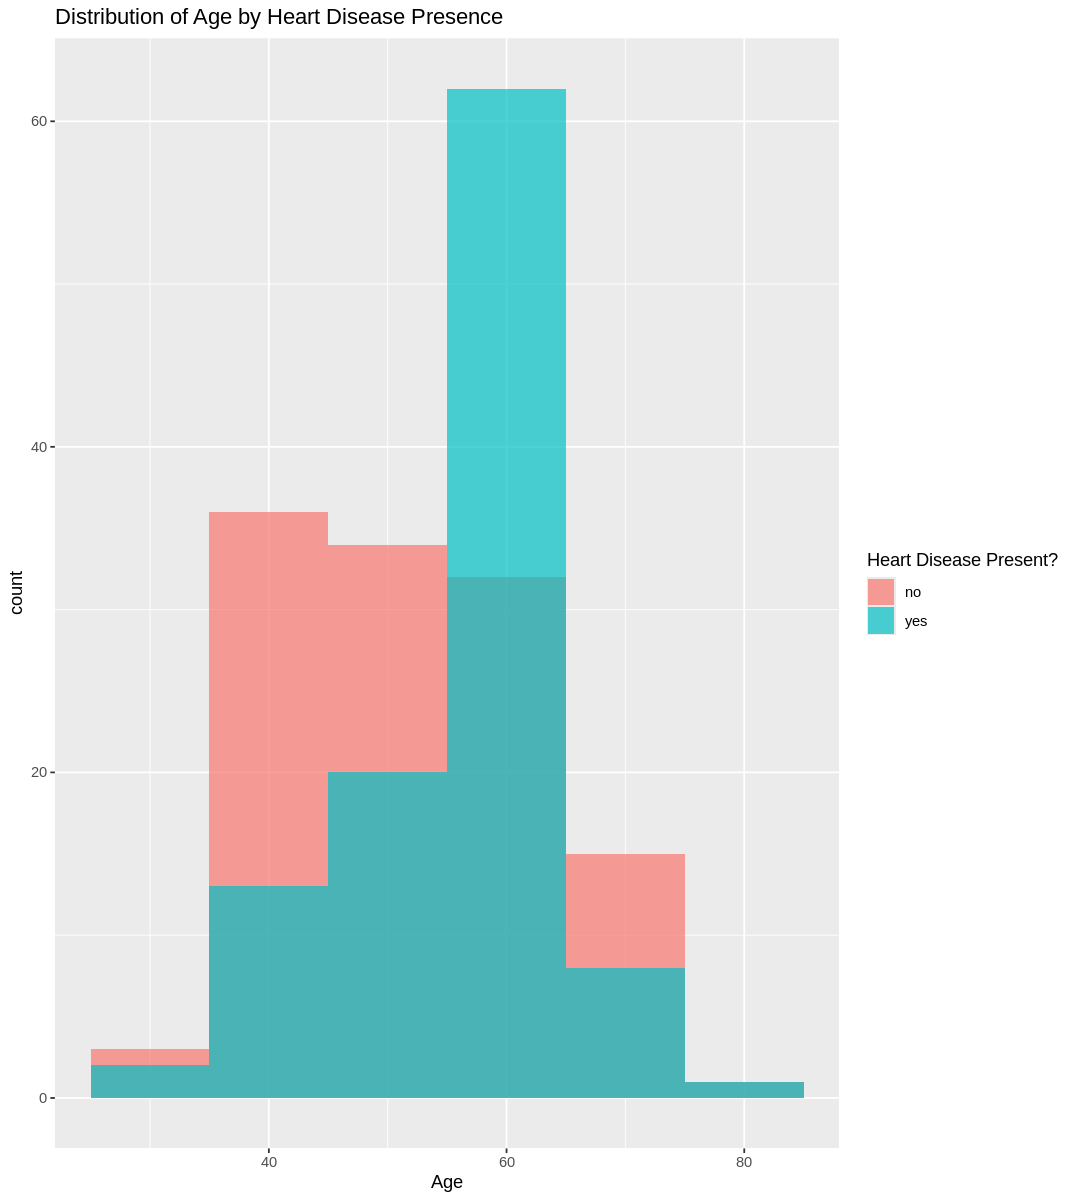

In [8]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Histogram of distribution of age by heart disease presence
age_vs_CVD <- cleveland_train |>
    ggplot(aes(x = age, fill = as_factor(num))) +
    geom_histogram(binwidth = 10, alpha = 0.7, position = "identity") +
    labs(title = "Distribution of Age by Heart Disease Presence", x = "Age", fill = "Heart Disease Present?")
age_vs_CVD

**Figure 1:** *Distribution of age coloured by heart disease presence*

The following histogram shows the prevalence of `chol` about the presence of heart disease, indicating whether the observation is labelled 'yes' or 'no' for heart disease. There are no obvious trends that differentiate the two classes in the distribution of cholesterol levels. A slight decreasing trend can be observed for the counts of patients with both **no** heart disease and **with** heart disease as serum cholesterol increases from around 230 mg/dL.

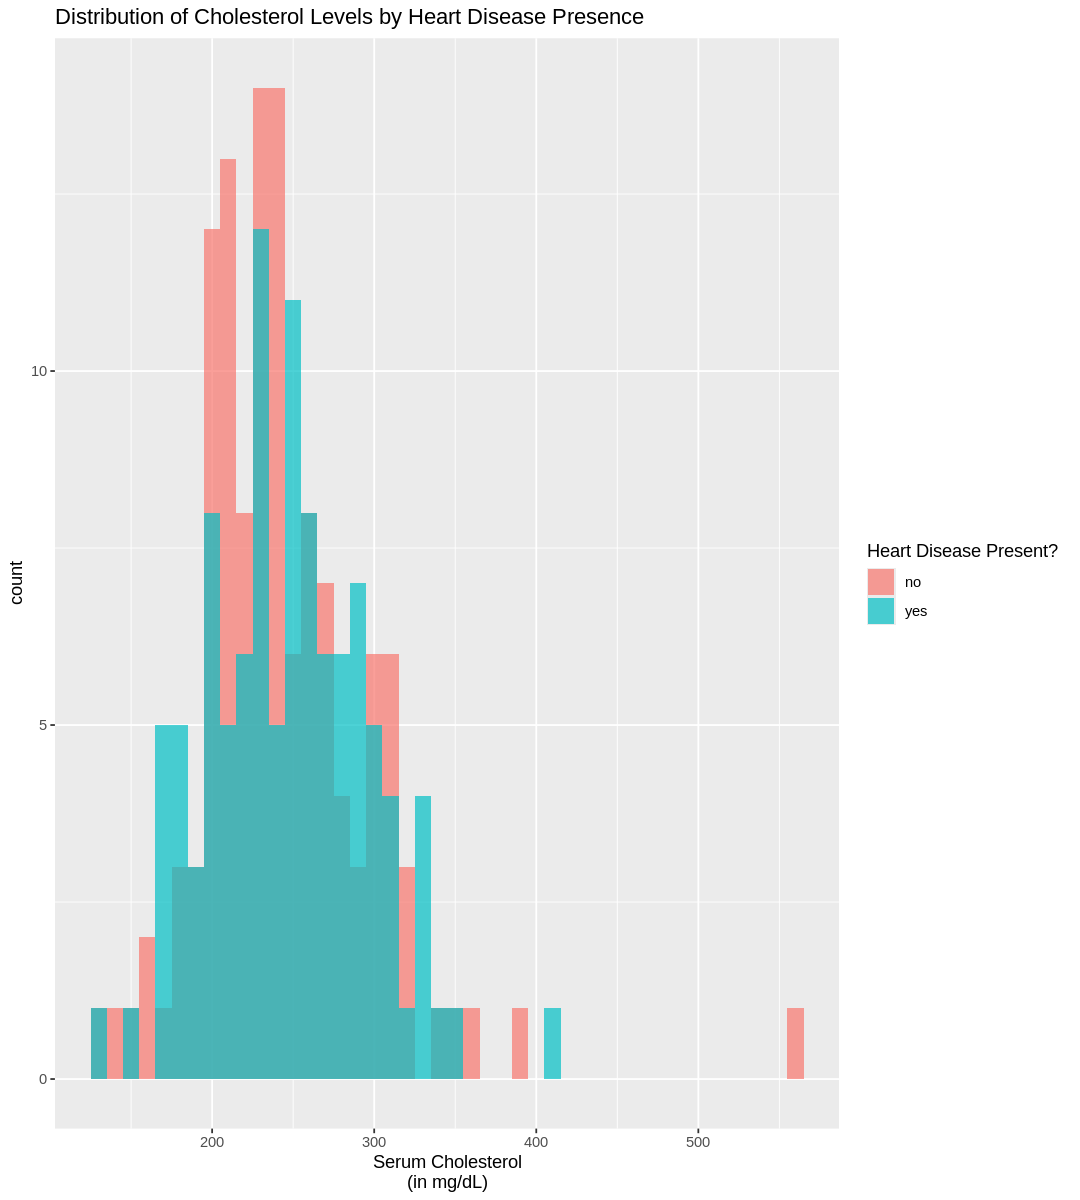

In [9]:
options(repr.plot.width = 9, repr.plot.height = 10)

# Histogram of distribution of serum cholesterol by heart disease presence
chol_vs_CVD <- cleveland_train |>
    ggplot(aes(x = chol, fill = as_factor(num))) +
    geom_histogram(binwidth = 10, alpha = 0.7, position = "identity") +
    labs(title = "Distribution of Cholesterol Levels by Heart Disease Presence", x = "Serum Cholesterol\n(in mg/dL)", fill = "Heart Disease Present?")
chol_vs_CVD

**Figure 2:** *Distribution of cholesterol levels coloured by heart disease presence*

The following histogram shows the prevalence of `trestbps` about the presence of heart disease, indicating whether the observation is labelled 'yes' or 'no' for heart disease. Again, there are no obvious trends that differentiate the two classes in the distribution of resting blood pressure. A decreasing trend can be observed for the counts of both patients with **no** heart disease and **with** heart disease as resting blood pressure increases from around 130 mmHg.

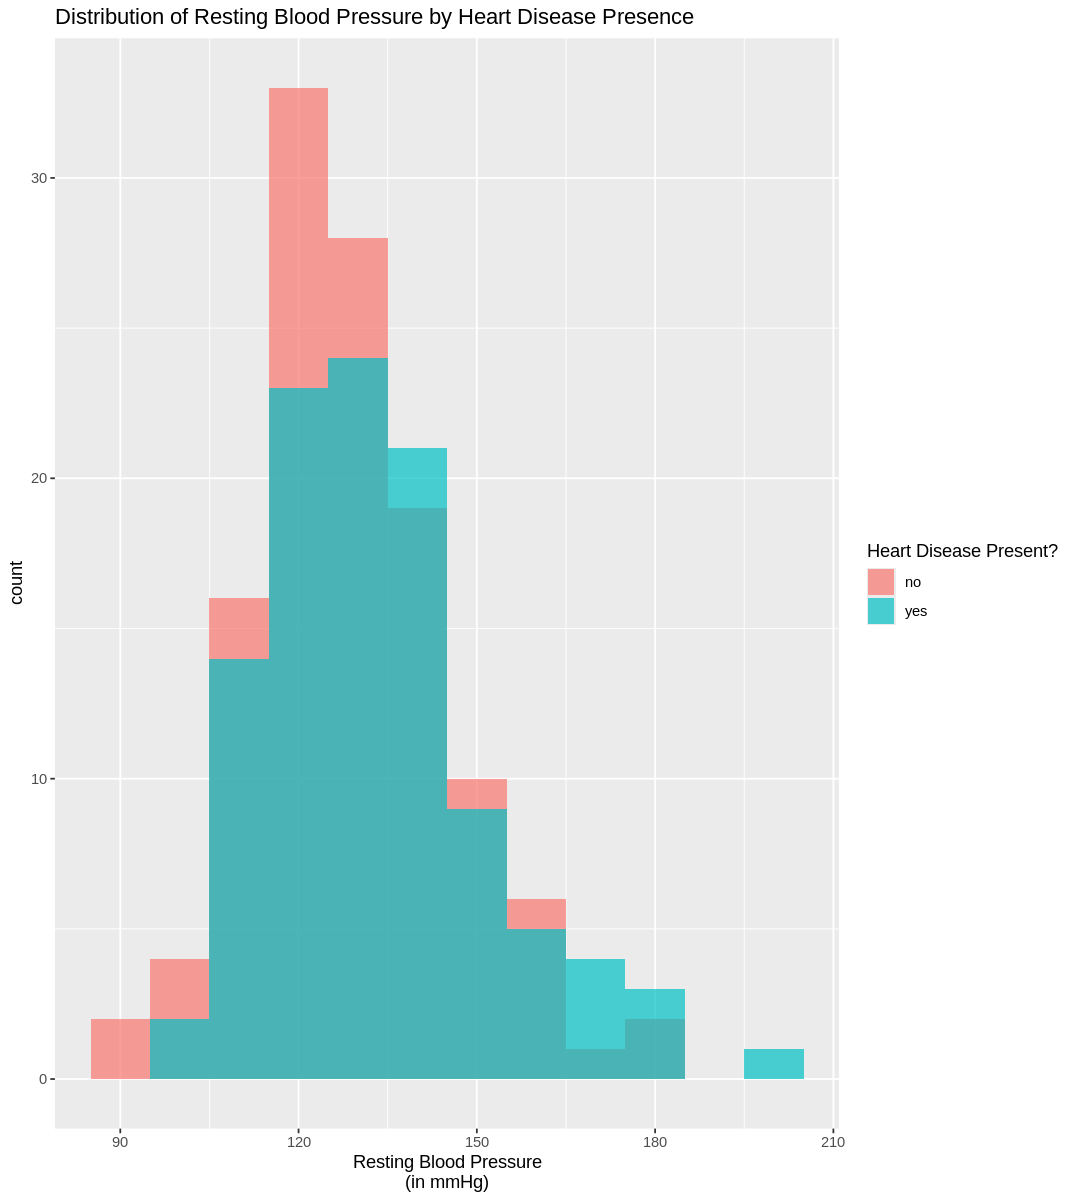

In [10]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Histogram of distribution of resting blood pressure by heart disease presence
trestbps_vs_CVD <- cleveland_train |>
    ggplot(aes(x = trestbps, fill = as_factor(num))) +
    geom_histogram(binwidth = 10, alpha = 0.7, position = "identity") +
    labs(title = "Distribution of Resting Blood Pressure by Heart Disease Presence", x = "Resting Blood Pressure\n(in mmHg)", fill = "Heart Disease Present?")
trestbps_vs_CVD

**Figure 3:** *Distribution of resting blood pressure coloured by heart disease presence*

The visualization below plots `age` (age) versus `trestbps` (resting blood pressure), labelling each observation according to its class as 'yes' or 'no' for heart disease. There is no strong correlation between the two variables, and several overlaps exist between the two classes ('yes' and 'no').

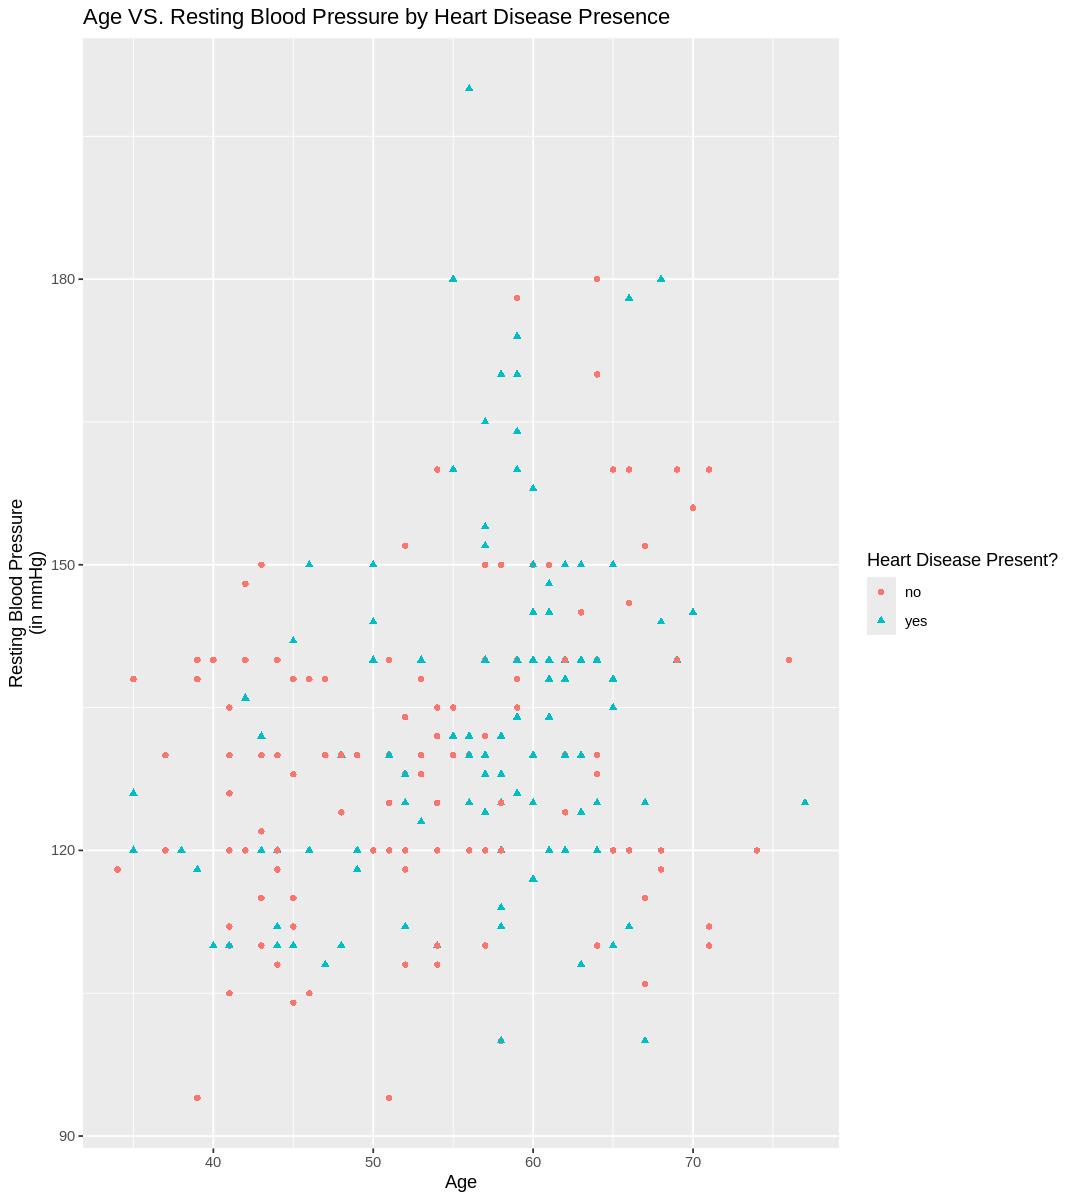

In [11]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Scatter plot of the relationship between age and resting blood pressure by heart disease presence
age_vs_trestbps <- cleveland_train |>
    ggplot(aes(x = age, y = trestbps, color = as_factor(num), shape = as_factor(num))) +
    geom_point() +
    labs(title = "Age VS. Resting Blood Pressure by Heart Disease Presence", x = "Age", y = "Resting Blood Pressure\n(in mmHg)",
         color = "Heart Disease Present?", shape = "Heart Disease Present?")
age_vs_trestbps

**Figure 4:** *Plot of age vs resting blood pressure*

The visualization below plots `age` (age) versus `chol` (serum cholesterol), labelling each observation according to its class as 'yes' or 'no' for heart disease. Compared to **Figure 4**, we can see a weaker correlation between age and cholesterol levels, several overlaps exist between the two classes ('yes' and 'no'), and there is no clear separation between them.

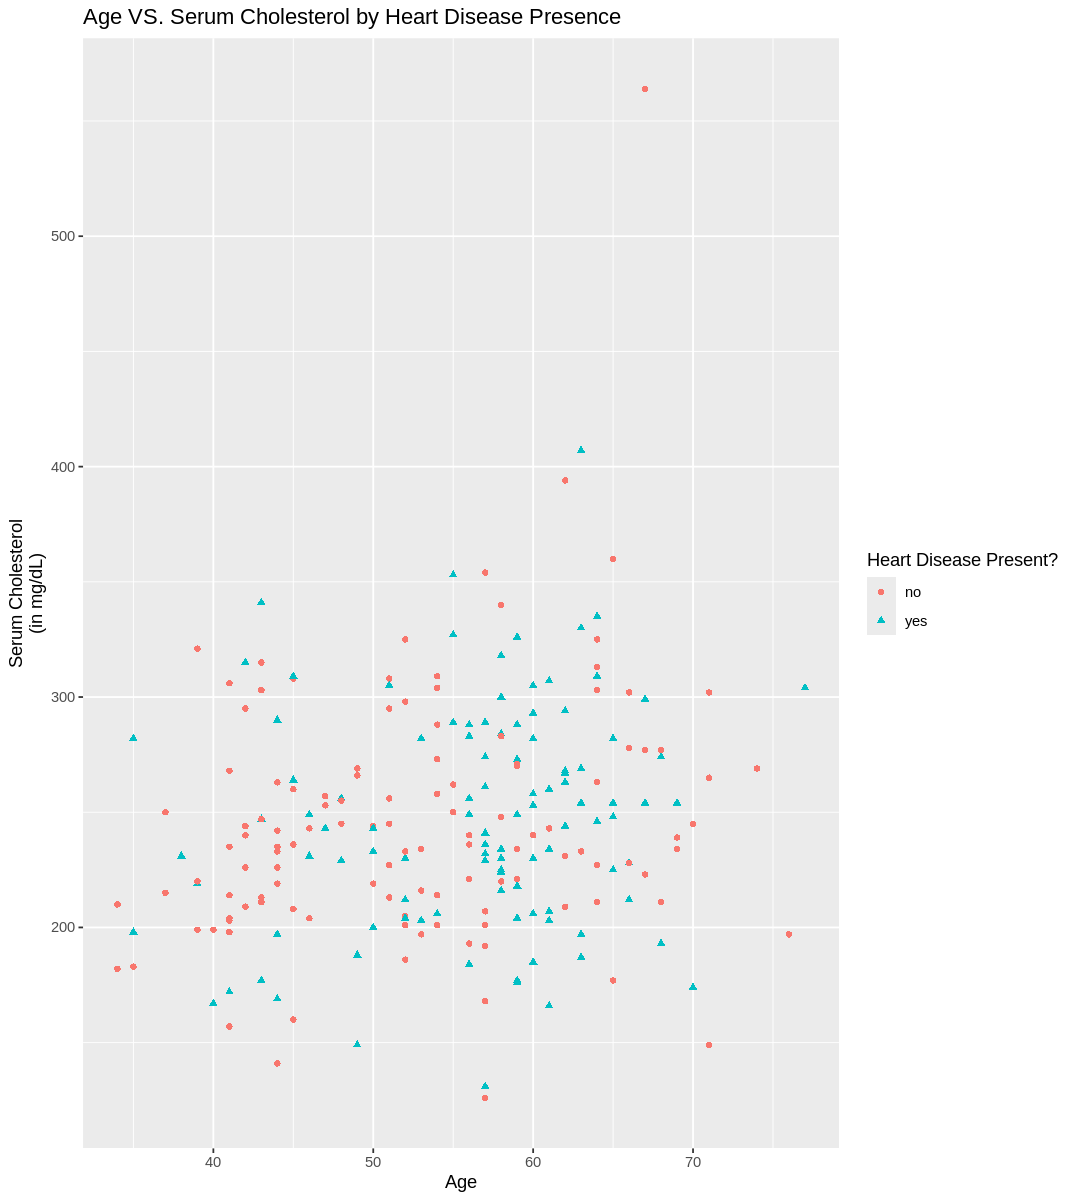

In [12]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Scatter plot of the relationship between age and serum cholesterol by heart disease presence
age_vs_chol <- cleveland_train |>
    ggplot(aes(x = age, y = chol, color = as_factor(num), shape = as_factor(num))) +
    geom_point() +
    labs(title = "Age VS. Serum Cholesterol by Heart Disease Presence", x = "Age", y = "Serum Cholesterol\n(in mg/dL)",
         color = "Heart Disease Present?", shape = "Heart Disease Present?")
age_vs_chol

**Figure 5:** *Plot of age vs cholesterol level*

The visualization below plots `chol` (serum cholesterol level) versus `trestbps` (resting blood pressure), labelling each observation according to its class as 'yes' or 'no' for heart disease. Compared to the previous plots in **Figure 4** and **Figure 5**, there is a stronger positive correlation between cholesterol level and resting blood pressure. However, even more overlaps exist between the two classes of heart disease presence, and there is still no clear separation between them.

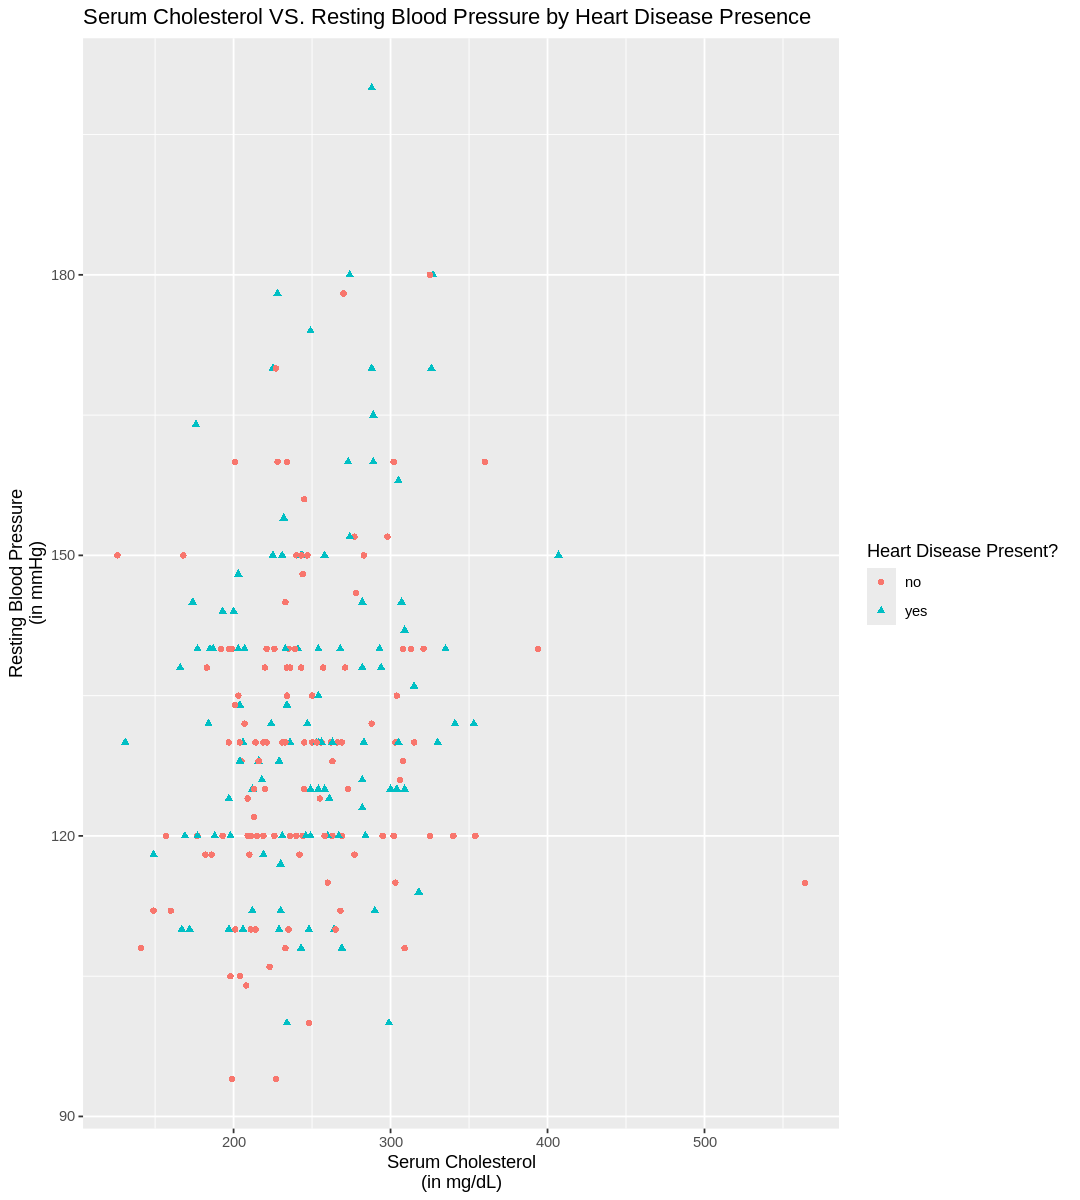

In [13]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Scatter plot of the relationship between serum cholesterol and resting blood pressure by heart disease presence
chol_vs_trestbps <- cleveland_train |>
    ggplot(aes(x = chol, y = trestbps, color = as_factor(num), shape = as_factor(num))) +
    geom_point() +
    labs(title = "Serum Cholesterol VS. Resting Blood Pressure by Heart Disease Presence", x = "Serum Cholesterol\n(in mg/dL)", y = "Resting Blood Pressure\n(in mmHg)",
        color = "Heart Disease Present?", shape = "Heart Disease Present?")
chol_vs_trestbps

**Figure 6:** *Plot of cholesterol level vs resting blood pressure*

### 2.5 Creating the Classification Model

To create the classification model, the first step is to create `knn_spec`, a model specification that calculates the Euclidean distance and uses KNN classification, with the number of neighbours set to `tune()` to enable cross-validation.

In [14]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

Then, the seed is set again to ensure the reproducibility of random splits, and the training data is divided into five folds for use in cross-validation using `heart_crossval`.

In [15]:
set.seed(123)

heart_crossval <- vfold_cv(cleveland_train, v = 5, strata = num)

A recipe, `heart_recipe`, is then created, specifying `num` as the label variable and `age`, `chol`, and `trestbps` as the predictor variables. This recipe scales and centres all of the data.

In [16]:
heart_recipe <- recipe(num ~ ., data = cleveland_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

Next, the first workflow, `heart_resample`, is created using `tune_grid()` to perform cross-validation.

In [17]:
heart_resample <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = heart_crossval)

The estimated accuracy of each number of neighbours is calculated using `metrics()`, which showed that 14 neighbours had the highest accuracy, although it was relatively low at 62%.

In [18]:
heart_crossval_metrics <- collect_metrics(heart_resample) |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
heart_crossval_metrics

k_val <- pull(heart_crossval_metrics[1,1])

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,accuracy,binary,0.6161702,5,0.01763118,Preprocessor1_Model9
9,accuracy,binary,0.5767376,5,0.01324755,Preprocessor1_Model6
10,accuracy,binary,0.5767376,5,0.01324755,Preprocessor1_Model7
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,accuracy,binary,0.5678487,5,0.01729941,Preprocessor1_Model8
3,accuracy,binary,0.5378723,5,0.02469905,Preprocessor1_Model2
2,accuracy,binary,0.4754610,5,0.02284261,Preprocessor1_Model1


**Table 5:** *Estimated accuracy of each k-value*

From the plot below, we can see that $K = 15$ provides the highest accuracy.

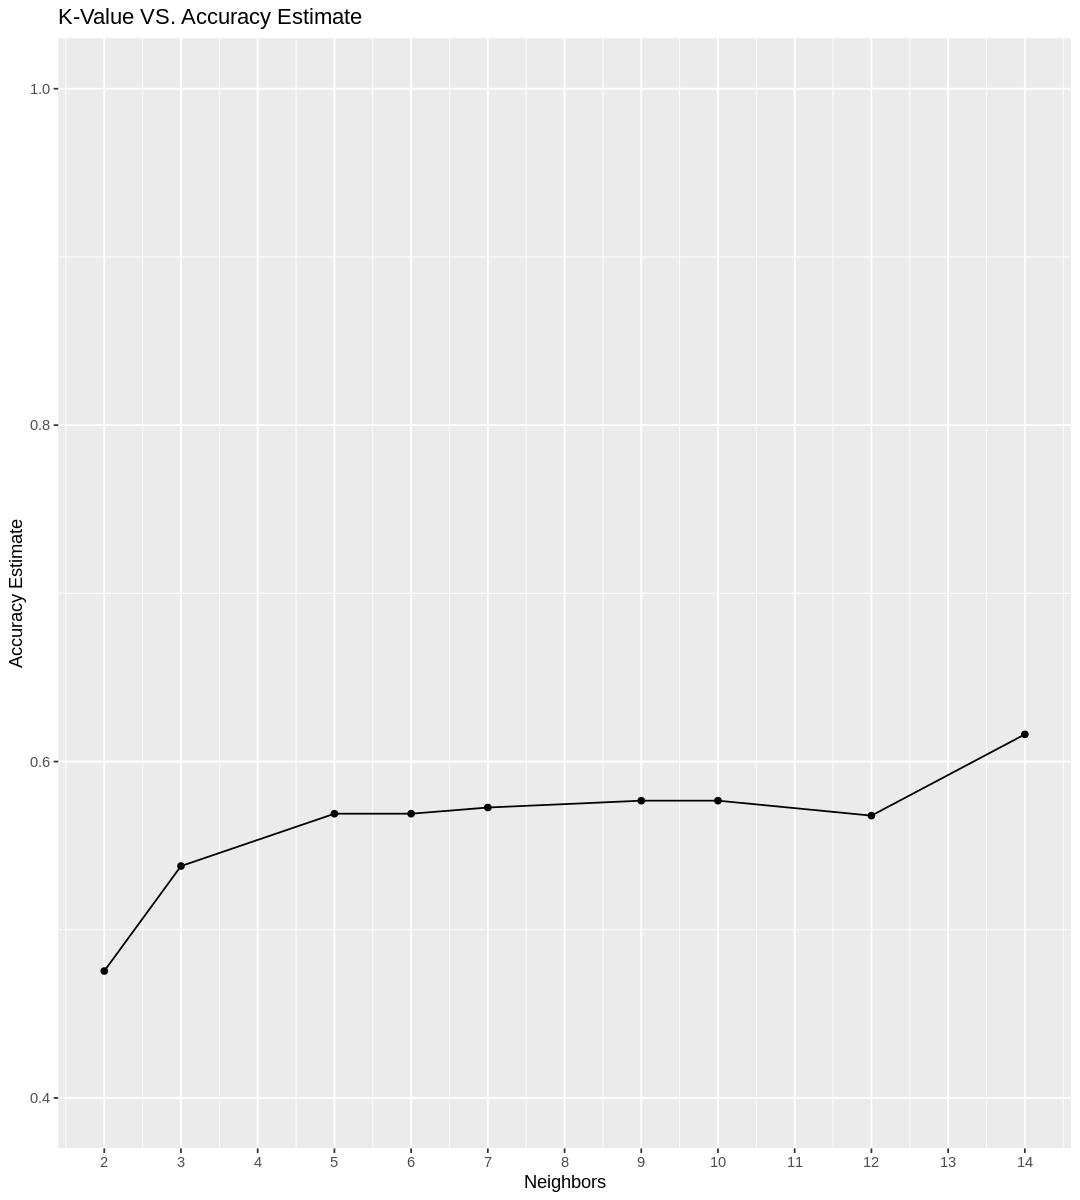

In [19]:
options(repr.plot.width = 9, repr.plot.height = 10)
accuracy_versus_k <- ggplot(heart_crossval_metrics, aes(x = neighbors, y = mean)) + 
    geom_point() +
    geom_line() +
    labs(title = "K-Value VS. Accuracy Estimate", x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0, 14, by = 1)) +
    scale_y_continuous(limits = c(0.4, 1.0))
accuracy_versus_k

**Figure 7:** *Plot of K-values vs accuracy*

A new model specification (`heart_spec`) and workflow (`heart_fit`) is created, now using the k-value with the highest accuracy and `fit()` instead of `tune_grid()`. The old recipe, `heart_recipe`, is reused since nothing has changed.

In [20]:
heart_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_val) |>
    set_engine("kknn") |>
    set_mode("classification")

heart_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(heart_spec) |>
    fit(data = cleveland_train)

The classification model can now be used to predict the `num` variable in the testing data, and the predictions can be appended to the testing dataset using `bind_cols()`.

In [21]:
heart_predictions <- predict(heart_fit, cleveland_test) |>
    bind_cols(cleveland_test)
heart_predictions

.pred_class,age,trestbps,chol,num
<fct>,<dbl>,<dbl>,<dbl>,<fct>
no,67,160,286,yes
yes,67,120,229,yes
yes,56,140,294,no
⋮,⋮,⋮,⋮,⋮
no,67,152,212,yes
yes,55,132,342,no
no,38,138,175,no


**Table 6:** *Predicted and actual outputs of the testing dataset*

### 2.6 Classification Results

An accuracy of  57% of the final classification is obtained using the `metrics()` function. An accuracy of 57% is low and smaller than the estimated accuracy (62%).

In [34]:
heart_accuracy <- heart_predictions |>
    metrics(truth = num, estimate = .pred_class) |>
    filter(.metric == "accuracy")
heart_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5657895


**Table 7:** *Accuracy of final classification model*

A confusion matrix of the predictions from the classification model is created using `conf_mat()`, revealing significant misclassifications – 19 outputs were incorrectly classified as 'no' and 14 as 'yes'.

In [23]:
heart_confusion <- heart_predictions |>
    conf_mat(truth = num, estimate = .pred_class)
heart_confusion

          Truth
Prediction no yes
       no  29  19
       yes 14  14

**Table 8:** *Confusion matrix for the final classification model*

Noting that the "positive" class, 'yes', corresponds to the second factor level, the precision and recall metrics is then computed using `recall()` and `precision()`. The output shows that the classification model has a very low estimated recall and precision of 42% and 50%, respectively.

In [31]:
heart_predictions |> pull(num) |> levels()

[1] "no"  "yes"

In [40]:
heart_recall <- heart_predictions |>
    recall(truth = num, estimate = .pred_class, event_level = "second")
heart_recall

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.4242424


**Table 9:** *Recall of final classification model*

In [41]:
heart_precision <- heart_predictions |>
    precision(truth = num, estimate = .pred_class, event_level = "second")
heart_precision

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5


**Table 10:** *Precision of final classification model*

### 2.7 Visualization of Data Analysis

Finally, visualizations of the classification results are created by replotting the original scatter plots, this time with the misidentified data points plotted as black squares. To achieve this, the misidentified points are filtered and added to the testing dataset with a new label of 'misclassified' under the `num` variable. This allows the data to be plotted and coloured by `num` in a new `ggplot()` scatter plot.

In [24]:
misclassified_predictions <- heart_predictions |>
    filter(.pred_class != num)

heart_accurate_prediction <- heart_predictions |>
    filter(.pred_class == num)

misclassified_subset <- subset(misclassified_predictions, select = -c(num)) |>
    cbind(c("misclassified"))

colnames(misclassified_subset) <- c(".pred_class", "age", "trestbps", "chol", "num")

misclassified_new <- mutate(misclassified_subset, num = as.factor(num)) |>
    rbind(heart_accurate_prediction, misclassified_subset)
misclassified_new

.pred_class,age,trestbps,chol,num
<fct>,<dbl>,<dbl>,<dbl>,<fct>
no,67,160,286,misclassified
yes,56,140,294,misclassified
yes,52,172,199,misclassified
⋮,⋮,⋮,⋮,⋮
no,55,128,205,misclassified
no,67,152,212,misclassified
yes,55,132,342,misclassified


**Table 11:** *New predicted dataset with the misclassified observations labeled as "misclassified"*

In the new scatter plot of age versus resting blood pressure, the misclassified points are spread throughout the entire dataset rather than concentrated in any specific area.

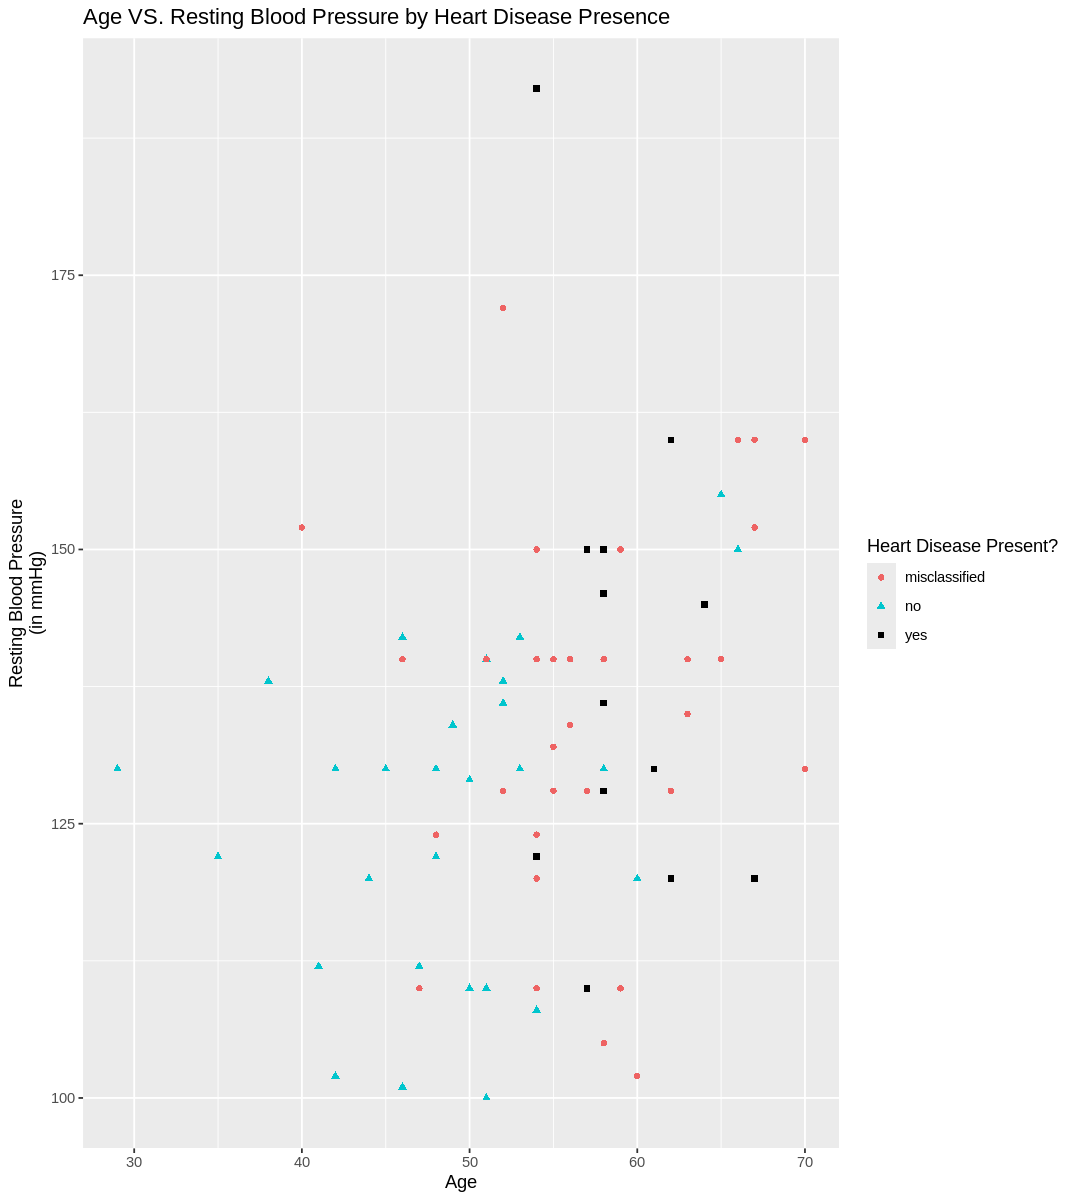

In [25]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Scatter plot of the relationship between age and resting blood pressure by heart disease presence
age_vs_trestbps_new <- misclassified_new |>
    ggplot(aes(x = age, y = trestbps, color = as_factor(num), shape = as_factor(num))) +
    geom_point() +
    labs(title = "Age VS. Resting Blood Pressure by Heart Disease Presence", x = "Age", y = "Resting Blood Pressure\n(in mmHg)",
         color = "Heart Disease Present?", shape = "Heart Disease Present?") +
    scale_color_manual(values = c("indianred2", "turquoise3", "black"))
age_vs_trestbps_new

**Figure 8:** *Plot of age vs resting blood pressure with incorrect predictions plotted as black squares*

Similarly, the misclassified points in the new scatter plot of age versus serum cholesterol level illustrated below are also scattered around and not condensed at a certain point.

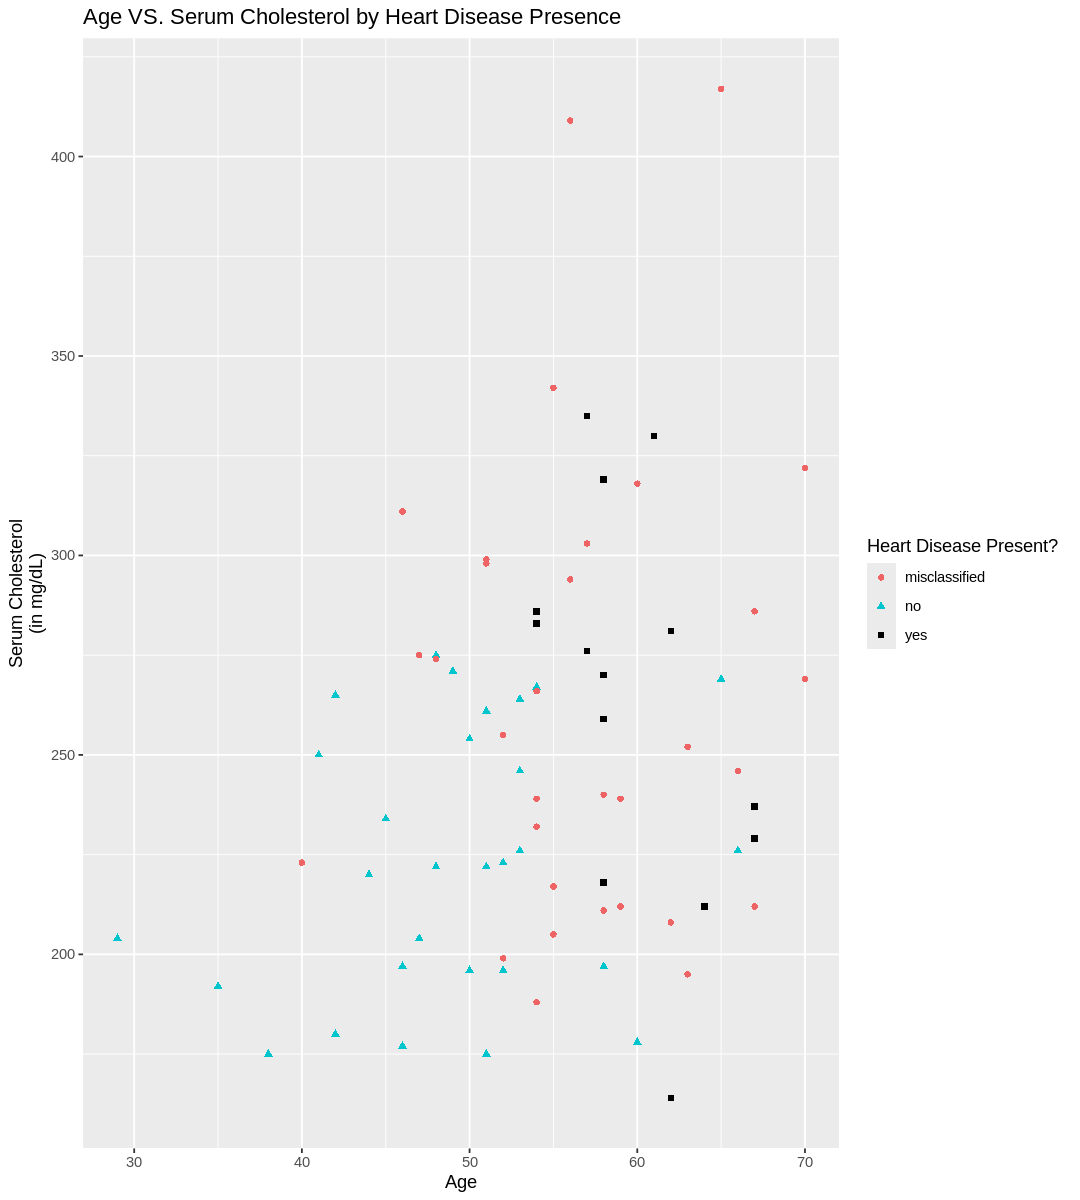

In [26]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Scatter plot of the relationship between age and serum cholesterol by heart disease presence
age_vs_chol <- misclassified_new |>
    ggplot(aes(x = age, y = chol, color = as_factor(num), shape = as_factor(num))) +
    geom_point() +
    labs(title = "Age VS. Serum Cholesterol by Heart Disease Presence", x = "Age", y = "Serum Cholesterol\n(in mg/dL)",
         color = "Heart Disease Present?", shape = "Heart Disease Present?") +
    scale_color_manual(values = c("indianred2", "turquoise3", "black"))
age_vs_chol

**Figure 9:** *Plot of age vs serum cholesterol levels with incorrect predictions plotted as black squares*

Lastly, in the new visualization plot of serum cholesterol level versus resting blood pressure, misclassified points are dispersed throughout the dataset and not fixed between points with different classifications.

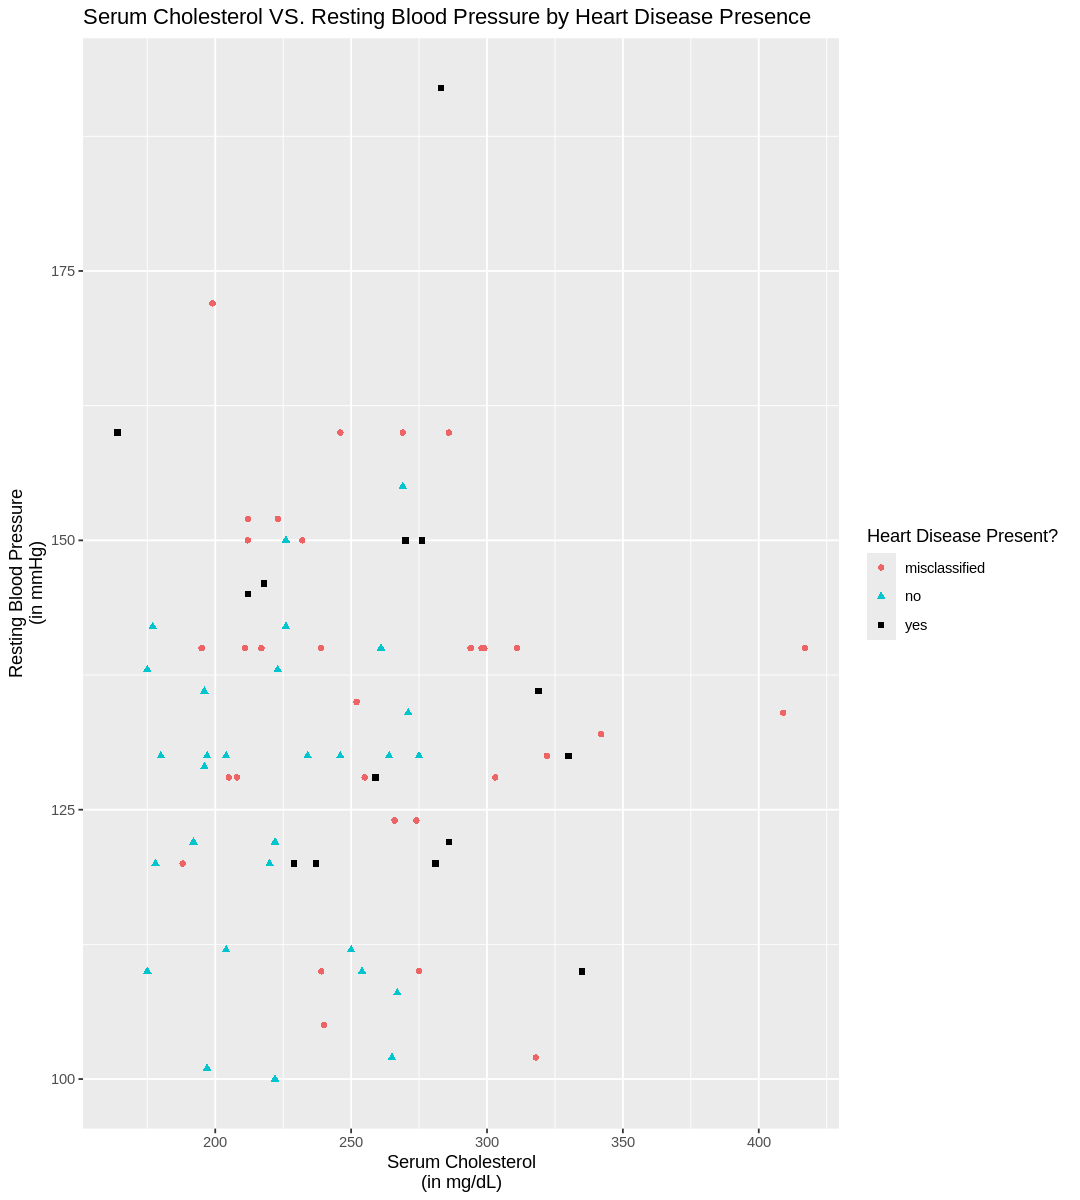

In [27]:
options(repr.plot.width = 9, repr.plot.height = 10)
# Scatter plot of the relationship between serum cholesterol and resting blood pressure by heart disease presence
chol_vs_trestbps <- misclassified_new |>
    ggplot(aes(x = chol, y = trestbps, color = as_factor(num), shape = as_factor(num))) +
    geom_point() +
    labs(title = "Serum Cholesterol VS. Resting Blood Pressure by Heart Disease Presence", x = "Serum Cholesterol\n(in mg/dL)", y = "Resting Blood Pressure\n(in mmHg)",
        color = "Heart Disease Present?", shape = "Heart Disease Present?") +
    scale_color_manual(values = c("indianred2", "turquoise3", "black"))
chol_vs_trestbps

**Figure 10:** *Plot of serum cholesterol levels vs resting blood pressure with incorrect predictions plotted as black squares*

## 3. Discussion

**What did you find?**

The research question was to predict the presence of heart disease ('yes' or 'no') based on the patient's age, cholesterol level, and resting blood pressure. There was no strong correlation found between age and resting blood pressure (**Figure 4**) nor between age and serum cholesterol (**Figure 5**). Both figures showed scattered observations with several overlaps between the 'yes' and 'no' classes, indicating no clear separation. In **Figure 6**, although a stronger correlation between cholesterol level and resting blood pressure was observed, there were still many overlaps between the two classes. 

Using a KNN classification model with 14 neighbours, the prediction accuracy for heart disease presence was 50%, with a precision of 60% and recall of 42%. 19 outputs were incorrectly classified as 'no' and 14 as 'yes' (false negative). This misdiagnosis could lead to consequential problems if the classification model is used in the real world. Patients who have heart disease but are classified as having 'no' heart disease will not receive appropriate medical attention. On the other hand, a false positive observation where the patient is predicted to have heart disease when the actual class is 'no' heart disease might be less bad, as the patient could consult with a doctor who can provide an expert diagnosis. Thus, in this case, a high recall is much needed, however, this has not been achieved by the classification model.  

The low accuracy and recall of the model which leads to numerous misclassified data can be attributed to the lack of clear trends in the distribution of cholesterol levels and resting blood pressure, which weakens the predictive power of the classification model. Additionally, the unclear separation between the classes shown by the predictors (age, cholesterol level, and resting blood pressure) makes it difficult for the model to distinguish patients with and without heart disease. Furthermore, noise and outliers in the dataset can adversely affect the model's performance, especially for KNN, which considers the proximity of data points. The data used to train and test the model may also be limited and cannot be used independently to predict the presence of heart disease in real-life settings or when the data is randomized.

**Is this what you expected to find?**

Considering the multifactorial nature of heart disease, it is anticipated for the classification model to achieve low accuracy, precision, and recall with only a subset of predictors. However, based on previous studies and researches, age, diastolic blood pressure, and serum cholesterol have shown significant associations with heart disease. Therefore, these variables may contribute meaningfully to predicting the presence of heart disease. Preliminary analysis suggests moderate predictive power, which may lead to a viable classification model. Specifically, older ages and higher diastolic pressure and cholesterol levels are likely to be associated with a higher risk of heart disease.

**What impact could such findings have?**

The success of the classification model could have significant implications for the healthcare sector, allowing healthcare professionals to identify at-risk individuals more efficiently. This would save time and resources, enabling quicker interventions and potentially improving patient outcomes. Moreover, the reduced number of required tests would make the screening process less invasive and more accessible to a broader population, facilitating earlier detection and treatment of heart disease.

**What future questions could this lead to?**

The low performance of the classification model, which uses age, cholesterol levels, and resting blood pressure as predictors, requires further research into alternative combinations or replacements of these variables to enhance predictive power. Additionally, while this model focuses on numerical variables, future research could include categorical variables like lifestyle habits and genetic markers to reinforce predictive accuracy. Exploring the interactions between these variables could also provide deeper insights. Also, further studies could evaluate the model's performance across different populations and settings, potentially leading to models that account for regional and demographic differences in heart disease prevalence.

## 4. References
*All references are formatted in MLA style*

* *Cardiovascular diseases (CVDs)*. (n.d.). Who.int. Retrieved June 3, 2024, from https://www.who.int/news-room/fact-sheets/detail/cardiovascular-diseases-(cvds)
* *CVD prevention: CVD risk assessment and treatment*. (n.d.). Org.uk. Retrieved June 5, 2024, from https://stpsupport.nice.org.uk/cholesterol/index.html
* Hossain, M. I., Maruf, M. H., Khan, M. A. R., Prity, F. S., Fatema, S., Ejaz, M. S., & Khan, M. A. S. (2023). Heart disease prediction using distinct artificial intelligence techniques: performance analysis and comparison. *Iran Journal of Computer Science*, 6(4), 397–417. https://doi.org/10.1007/s42044-023-00148-7
* Loskot, F., & Novotny, P. (1990). Asymptomatic myocardial ischemia. *Zeitschrift Für Die Gesamte Innere Medizin Und Ihre Grenzgebiete*, 45(13). https://pubmed.ncbi.nlm.nih.gov/2238747/
* Virani, S. S., Alonso, A., Benjamin, E. J., Bittencourt, M. S., Callaway, C. W., Carson, A. P., Chamberlain, A. M., Chang, A. R., Cheng, S., Delling, F. N., Djousse, L., Elkind, M. S. V., Ferguson, J. F., Fornage, M., Khan, S. S., Kissela, B. M., Knutson, K. L., Kwan, T. W., Lackland, D. T., … On behalf of the American Heart Association Council on Epidemiology and Prevention Statistics Committee and Stroke Statistics Subcommittee. (2020). Heart disease and stroke statistics—2020 update: A report from the American Heart Association. *Circulation*, 141(9). https://doi.org/10.1161/cir.0000000000000757